var model 

In [1]:
import sys
sys.path.insert(0, '../')
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import re
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from jupyterthemes import jtplot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import itertools
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR






In [2]:
df = pd.read_pickle('f_data')
df.head() 

,Page,Type_of_traffic,Agent,lang,Date,count
0,2NE1,all-access,spider,zh,2015-07-01,18.0
1,2PM,all-access,spider,zh,2015-07-01,11.0
2,3C,all-access,spider,zh,2015-07-01,1.0
3,4minute,all-access,spider,zh,2015-07-01,35.0
4,52_Hz_I_Love_You,all-access,spider,zh,2015-07-01,NaN


In [3]:
def divide_page_by_lang(data_melted, page_name):

    my_page = data_melted[data_melted.Page == page_name]

    languages = my_page.lang.unique()
    lang_sets = {}
    for key in languages:
        lang_sets[key] = my_page[my_page.lang ==
                                 key][['Date', 'Page', 'lang', 'count']]

    data = pd.DataFrame(index=lang_sets[languages[0]].Date.unique())
    for key in languages:
        data[key] = lang_sets[key].groupby('Date')['count'].sum().values

    return data

In [4]:
k = df[df.Page == '2PM']
k

,Page,Type_of_traffic,Agent,lang,Date,count
1,2PM,all-access,spider,zh,2015-07-01,11.0
28141,2PM,all-access,all-agents,zh,2015-07-01,1571.0
60571,2PM,desktop,all-agents,zh,2015-07-01,989.0
105178,2PM,mobile-web,all-agents,zh,2015-07-01,575.0
145064,2PM,all-access,spider,zh,2015-07-02,14.0
...,...,...,...,...,...,...
79599702,2PM,mobile-web,all-agents,zh,2016-12-30,281.0
79639588,2PM,all-access,spider,zh,2016-12-31,20.0
79667728,2PM,all-access,all-agents,zh,2016-12-31,628.0
79700158,2PM,desktop,all-agents,zh,2016-12-31,292.0


In [5]:
 m = k['lang'].nunique
 m    

<bound method IndexOpsMixin.nunique of 1           zh
28141       zh
60571       zh
105178      zh
145064      zh
            ..
79599702    zh
79639588    zh
79667728    zh
79700158    zh
79744765    zh
Name: lang, Length: 2200, dtype: object>

In [6]:
page1 = divide_page_by_lang(df,'ASCII')
page1

,zh,es,ru
2015-07-01,1672.0,1015.0,623.0
2015-07-02,1923.0,1101.0,584.0
2015-07-03,1576.0,775.0,547.0
2015-07-04,570.0,468.0,436.0
2015-07-05,614.0,460.0,316.0
...,...,...,...
2016-12-27,3089.0,571.0,801.0
2016-12-28,3270.0,631.0,735.0
2016-12-29,3196.0,589.0,610.0
2016-12-30,2511.0,491.0,494.0


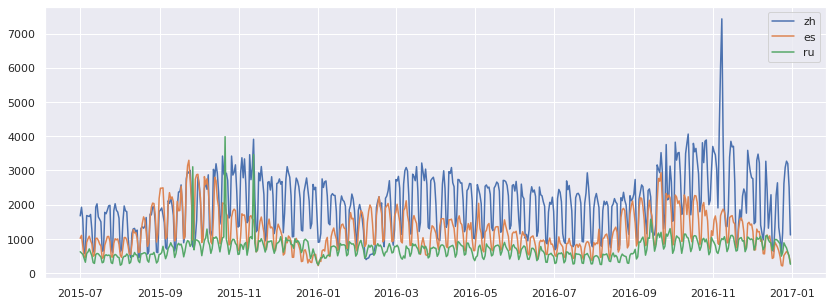

In [33]:
for key in page1.columns:
    fig = plt.figure(1,figsize=[14,5])
    plt.plot(page1[key], label = key , linewidth = 1.5)
    
plt.legend()
plt.show()


In [8]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [(test_result[i+1][0][test][1],12) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df



In [9]:
gc_df =  grangers_causation_matrix(page1, variables = page1.columns)        
gc_df


,zh_x,es_x,ru_x
zh_y,1.000000e+00,3.400558e-16,1.199555e-06
es_y,2.237236e-12,1.000000e+00,8.684577e-09
ru_y,2.927851e-13,4.605868e-26,1.000000e+00


In [10]:
#float("8.99284722486562e-02")
# and now with 'rounding'
"{:.12f}".format(float("2.237236e-12")) 

'0.000000000002'

In [ ]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)
        




In [12]:
cointegration_test(page1)


Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
zh     ::  66.96     > 24.2761   =>   True
es     ::  14.64     > 12.3212   =>   True
ru     ::  0.92      > 4.1296    =>   False


In [13]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

          
          
          
def plot_arima(train, test, predictions, title):
    plt.figure(figsize=(17, 9))
    titles = ['prediction', 'reality']
    plt.plot(test.index, predictions, color='orange', linewidth=1.5)
    plt.plot(test.index, test, color='b', linewidth=1.5)
    plt.plot(train.index, train, color='b', linewidth=1.5)
    plt.legend(titles)
    plt.ylabel('Series')
    plt.title('Performance of predictions - Benchmark Predictions vs Reality ' + title)
    plt.show()
              

In [14]:
for name, column in page1.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "zh" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.4056
 No. Lags Chosen       = 19
 Critical value 1%     = -3.443
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.1402. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "es" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.4626
 No. Lags Chosen       = 15
 Critical value 1%     = -3.443
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.1248. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "ru" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. No

In [15]:
page1_diff = page1.diff().dropna()

In [16]:
for name, column in page1_diff.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "zh" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.9704
 No. Lags Chosen       = 19
 Critical value 1%     = -3.443
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "es" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.5559
 No. Lags Chosen       = 19
 Critical value 1%     = -3.443
 Critical value 5%     = -2.867
 Critical value 10%    = -2.57
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ru" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test 

In [17]:
model = VAR(page1_diff)
for i in range(1,20):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n') 

Lag Order = 1
AIC :  35.69102834531159
BIC :  35.785326344295854
FPE :  3165315479596868.5
HQIC:  35.72788434012626 

Lag Order = 2
AIC :  35.36114185456659
BIC :  35.52639491645117
FPE :  2275886510619744.5
HQIC:  35.42573551602648 

Lag Order = 3
AIC :  35.24979139912668
BIC :  35.486199035156616
FPE :  2036081839025023.0
HQIC:  35.34220516368158 

Lag Order = 4
AIC :  34.920069360345686
BIC :  35.22783201354177
FPE :  1464216253103417.2
HQIC:  35.04038605701472 

Lag Order = 5
AIC :  34.21511837648574
BIC :  34.59443742767891
FPE :  723534458462468.5
HQIC:  34.3634212294164 

Lag Order = 6
AIC :  33.970633542466956
BIC :  34.42171131638268
FPE :  566625262128789.9
HQIC:  34.14700617351529 

Lag Order = 7
AIC :  33.791662805024224
BIC :  34.31470257641725
FPE :  473795395498654.56
HQIC:  33.9961892363563 

Lag Order = 8
AIC :  33.718708614292964
BIC :  34.313914614133054
FPE :  440488840439285.5
HQIC:  33.95147327100804 

Lag Order = 9
AIC :  33.66350273339888
BIC :  34.3310801551079

In [18]:
# select lag order 16 
train_size = int(0.66*page1_diff.shape[0])
train = page1_diff.iloc[:train_size,:]
test = page1_diff.iloc[train_size:, :] 

In [19]:
history = train.copy()
predictions = pd.DataFrame(columns=train.columns)
    
model = VAR(history)
model_fit = model.fit(maxlags=16, ic='aic')
lag_order = model_fit.k_ar
output = model_fit.forecast(test.values[:], steps = test.shape[0])
pred = output

In [20]:
model_fit.summary()


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 07, Dec, 2019
Time:                     08:35:20
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    35.1531
Nobs:                     346.000    HQIC:                   34.1697
Log likelihood:          -7124.63    FPE:                3.62724e+14
AIC:                      33.5189    Det(Omega_mle):     2.43789e+14
--------------------------------------------------------------------
Results for equation zh
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const          3.063832        18.000361            0.170           0.865
L1.zh         -0.384664         0.059753           -6.438           0.000
L1.es         -0.090531         0.103256           -0.877           0.381
L1.ru         -0.

In [21]:
pred = pd.DataFrame(pred)
pred.columns = test.columns

In [22]:
pred

,zh,es,ru
0,269.605023,10.424660,141.321814
1,803.620659,284.328179,267.388618
2,432.238666,172.506498,174.434228
3,45.093676,-53.708591,133.383362
4,-379.573935,-101.368972,-190.040019
...,...,...,...
182,13.504828,2.606574,0.519649
183,259.251442,161.685121,48.833321
184,197.896294,140.845050,49.344452
185,60.435805,40.066265,26.313056


In [23]:
pred.index = test.index

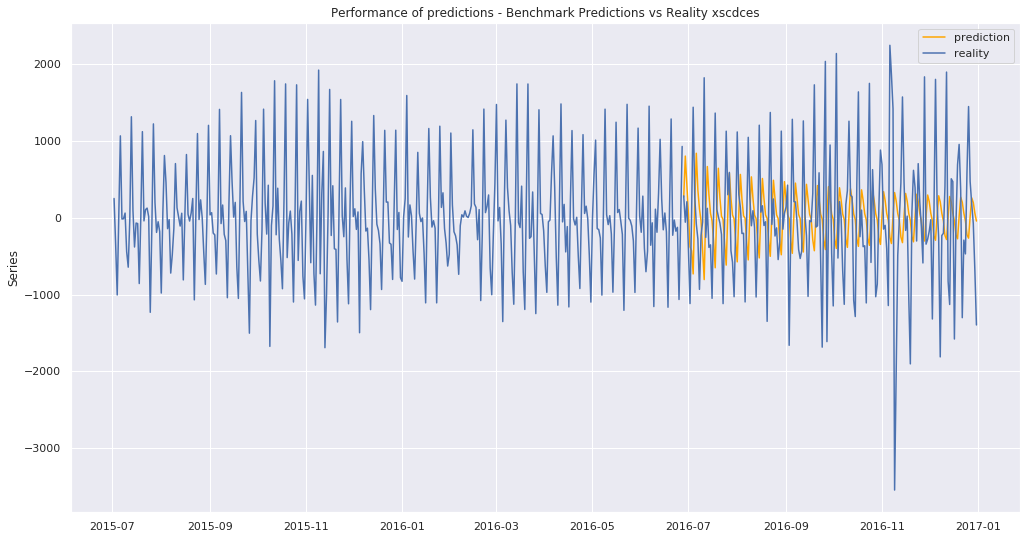

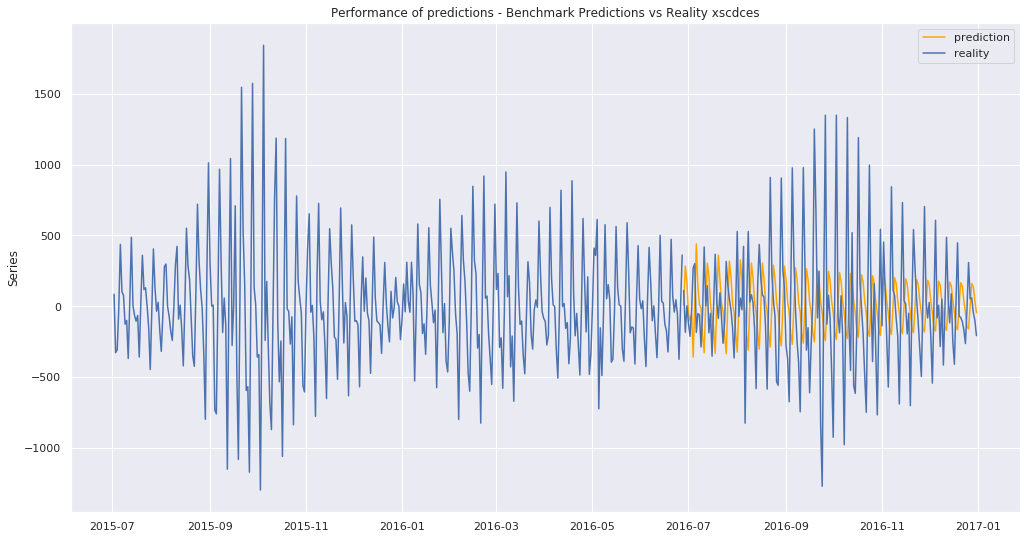

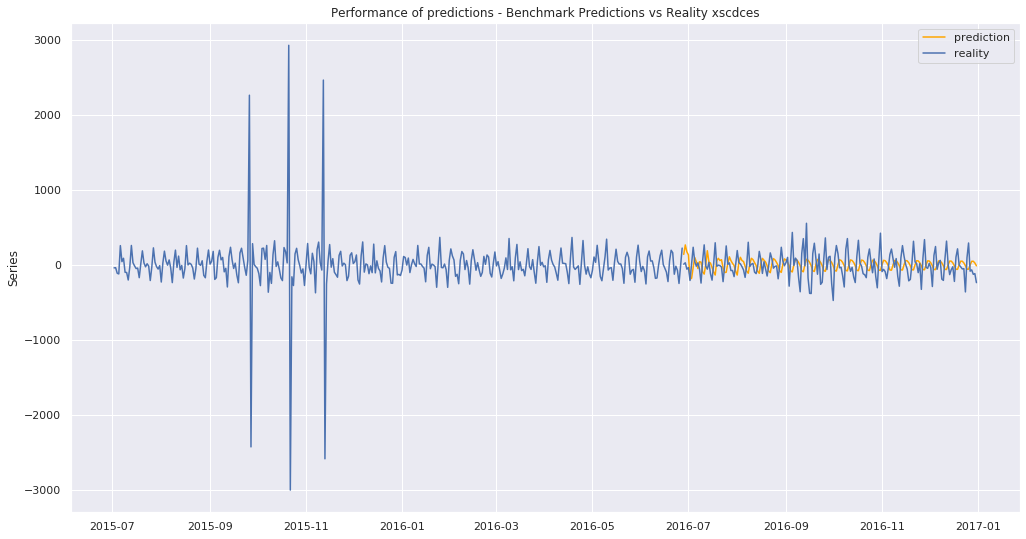

In [24]:
for key in page1_diff.columns:
    plot_arima(train[key], test[key], pred[key],'xscdces') 

In [26]:
page1_diff

,zh,es,ru
2015-07-02,251.0,86.0,-39.0
2015-07-03,-347.0,-326.0,-37.0
2015-07-04,-1006.0,-307.0,-111.0
2015-07-05,44.0,-8.0,-120.0
2015-07-06,1067.0,437.0,258.0
...,...,...,...
2016-12-27,472.0,54.0,-83.0
2016-12-28,181.0,60.0,-66.0
2016-12-29,-74.0,-42.0,-125.0
2016-12-30,-685.0,-98.0,-116.0


In [37]:
def smape(A, F):
    A, F = np.array(A), np.array(F)
    return np.mean(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))*100

In [38]:
new = pd.DataFrame(
    {'actual': train,
    'fitted': model_fit.fittedvalues} 
     )
new

ValueError: If using all scalar values, you must pass an index

In [45]:
 train1 = train[16:] 
train1    

,zh,es,ru
2015-07-18,-857.0,-357.0,-170.0
2015-07-19,12.0,25.0,19.0
2015-07-20,1122.0,360.0,188.0
2015-07-21,-41.0,119.0,27.0
2015-07-22,106.0,131.0,-25.0
...,...,...,...
2016-06-23,-175.0,47.0,-17.0
2016-06-24,-125.0,-56.0,-72.0
2016-06-25,-1065.0,-373.0,-247.0
2016-06-26,-38.0,10.0,-3.0


In [49]:
fitted = model_fit.fittedvalues
fitted

,zh,es,ru
2015-07-18,-740.760156,-298.602319,-119.881634
2015-07-19,80.202085,47.966747,-55.615477
2015-07-20,1102.949174,440.225372,267.265412
2015-07-21,63.541397,102.597700,-32.884872
2015-07-22,-50.014270,4.661771,-34.394752
...,...,...,...
2016-06-23,-155.606721,-88.031423,16.840649
2016-06-24,-234.550280,-163.214563,-203.045952
2016-06-25,-757.466731,-405.839768,-86.995448
2016-06-26,171.418049,-105.142659,146.134558


In [50]:
new = pd.DataFrame(
    {'actual_zh': train1['zh'],
    'fitted':fitted['zh'] } 
     )
new

,actual_zh,fitted
2015-07-18,-857.0,-740.760156
2015-07-19,12.0,80.202085
2015-07-20,1122.0,1102.949174
2015-07-21,-41.0,63.541397
2015-07-22,106.0,-50.014270
...,...,...
2016-06-23,-175.0,-155.606721
2016-06-24,-125.0,-234.550280
2016-06-25,-1065.0,-757.466731
2016-06-26,-38.0,171.418049


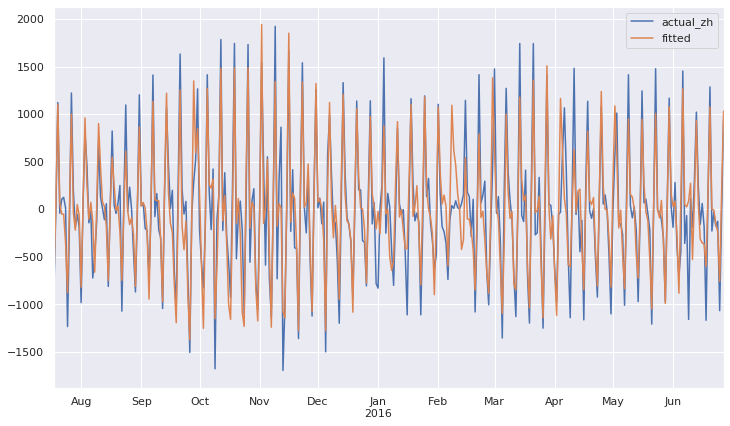

In [51]:
new.plot(figsize = (12,7) )

In [52]:
print('Classical multiplicative model SMAPE:{:10.4f}'.format(smape(new['actual_zh'],new['fitted']))) 

Classical multiplicative model SMAPE:   94.4922
